In [1]:
import numpy as np
import pandas as pd
from sklearn import preprocessing
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, KFold
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
import matplotlib
from matplotlib import pyplot as plt
from nltk.classify import NaiveBayesClassifier
from sklearn.svm import LinearSVC
from nltk.classify.scikitlearn import SklearnClassifier
from nltk.classify.util import accuracy as nltk_accuracy
import mysql.connector

%matplotlib inline

In [2]:
connection = mysql.connector.connect(
        host='ds50-mysql-do-user-9644544-0.b.db.ondigitalocean.com',
        database='ds50',
        user='ds50',
        password='AVNS_4ybSd0CoPKnCL5F',
        port = '25060')
if connection.is_connected():
        data = pd.read_sql( 'SELECT * FROM REVIEW LIMIT 5000', connection)
        connection.close()
data=pd.DataFrame(data)


C:\Users\antoi\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\io\sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   review_id    5000 non-null   object        
 1   user_id      5000 non-null   int64         
 2   book_id      5000 non-null   int64         
 3   rating       5000 non-null   int64         
 4   review_text  5000 non-null   object        
 5   date_added   5000 non-null   datetime64[ns]
 6   started_at   3127 non-null   datetime64[ns]
 7   n_votes      5000 non-null   int64         
 8   n_comments   5000 non-null   int64         
dtypes: datetime64[ns](2), int64(5), object(2)
memory usage: 351.7+ KB


In [3]:
data = data[(data['review_text'].str.len() > 3) & (data['review_text'].str.len() < 3000) & (((~ data['review_text'].str.isdigit()) & (data['review_text'].str.len() != 0)) | (data['rating'] != 0))]


In [4]:
data.shape
data = data.reset_index()
data = data.drop(columns=["index"])
data.head(15)

,review_id,user_id,book_id,rating,review_text,date_added,started_at,n_votes,n_comments
0,00005dd943695f048c7348a06c6408db,296741,9409458,2,The final book in the Mercy Falls trilogy left...,2017-08-23 13:16:33,2017-08-23 07:00:00,0,0
1,0000f2fa08114079d9d7215bc5e754d2,155648,24817626,1,I reread To Kill a Mockingbird prior to readin...,2015-04-25 11:36:35,2016-08-13 07:00:00,1,0
2,0001a480a5b24fdad0633417a76b6bb0,266353,26891429,5,A very satisfying conclusion to this entertain...,2016-06-18 21:15:55,2016-06-18 07:00:00,0,0
3,0001b032e98876009c59acc94cca8194,91247,17167166,5,"""Why are you crying?"" \n ""Because,"" she whispe...",2015-12-18 15:34:29,2016-09-29 07:00:00,29,0
4,00020adeea578404ffa05e295fb2b182,253237,18966322,0,"I am interested in this world, but the series ...",2014-01-10 07:41:32,NaT,0,0
5,000226ba8be15e77f5dc8bd833c4b35e,29129,3257136,4,Dewey: The Small-Town Library Cat Who Touched ...,2008-12-29 22:47:59,NaT,1,0
6,000290a64894dd0368ae64ea3999b618,188877,18798983,4,A reinvention of the 'Thousand Arabian Nights'...,2016-02-16 19:18:39,NaT,0,0
7,0002d163004e23746d389390b3c39975,246898,12607835,5,Becoming a Butterfly discusses a topic that I'...,2012-04-25 22:26:30,2012-04-25 07:00:00,2,0
8,0002d890f8cb3236ff342f07e59ffd0b,17369,6514,4,** spoiler alert ** \n I was reading so many b...,2009-02-14 05:46:35,NaT,0,0
9,0002e65d17b9eba2098951b225ff28ae,236576,16101128,4,The 5th Wave is a post apocalyptic novel deali...,2013-05-18 15:29:11,2013-05-18 07:00:00,1,0


In [5]:
def isfloat(num):
    try:
        float(num)
        return True
    except ValueError:
        return False


In [6]:
import re 
import nltk
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger')

# to remove stopword
from nltk.corpus import stopwords, wordnet
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.tag import pos_tag
from nltk.stem import WordNetLemmatizer

corpus = []

def convert_pos(pos):
    if pos[0] in POS_CONVERSION:
        return POS_CONVERSION[pos[0]]
    else:
        return wordnet.NOUN

def remove_punctuation(text):
    import string
    translator = str.maketrans('', '', string.punctuation)
    return text.translate(translator)


for i in range(0, len(data)):
    #We remove punctuation
    review = remove_punctuation(data.loc[i,'review_text'])

    # convert all cases to lower cases
    review = review.lower()

    # split to array(default delimiter is " ")
    review = nltk.word_tokenize(review)

    POS_CONVERSION = {"N": wordnet.NOUN, "V": wordnet.VERB, "J": wordnet.ADJ, "R": wordnet.ADV}

    tags = pos_tag(review)
    lemmatizer = WordNetLemmatizer()
    
    review = [lemmatizer.lemmatize(word, pos=convert_pos(pos)) for word, pos in tags
                if word not in set(stopwords.words("english"))]

    review = ' '.join(review)
    
    corpus.append(review)
    
    data.loc[i,'review_text']=review

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\antoi\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\antoi\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\antoi\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\antoi\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


je suis ligne 0
je suis ligne 1
je suis ligne 2
je suis ligne 3
je suis ligne 4
je suis ligne 5
je suis ligne 6
je suis ligne 7
je suis ligne 8
je suis ligne 9
je suis ligne 10
je suis ligne 11
je suis ligne 12
je suis ligne 13
je suis ligne 14
je suis ligne 15
je suis ligne 16
je suis ligne 17
je suis ligne 18
je suis ligne 19
je suis ligne 20
je suis ligne 21
je suis ligne 22
je suis ligne 23
je suis ligne 24
je suis ligne 25
je suis ligne 26
je suis ligne 27
je suis ligne 28
je suis ligne 29
je suis ligne 30
je suis ligne 31
je suis ligne 32
je suis ligne 33
je suis ligne 34
je suis ligne 35
je suis ligne 36
je suis ligne 37
je suis ligne 38
je suis ligne 39
je suis ligne 40
je suis ligne 41
je suis ligne 42
je suis ligne 43
je suis ligne 44
je suis ligne 45
je suis ligne 46
je suis ligne 47
je suis ligne 48
je suis ligne 49
je suis ligne 50
je suis ligne 51
je suis ligne 52
je suis ligne 53
je suis ligne 54
je suis ligne 55
je suis ligne 56
je suis ligne 57
je suis ligne 58
je suis

In [7]:
data.head(15)

,review_id,user_id,book_id,rating,review_text,date_added,started_at,n_votes,n_comments
0,00005dd943695f048c7348a06c6408db,296741,9409458,2,final book mercy fall trilogy leave mixed feel...,2017-08-23 13:16:33,2017-08-23 07:00:00,0,0
1,0000f2fa08114079d9d7215bc5e754d2,155648,24817626,1,reread kill mockingbird prior read go set watc...,2015-04-25 11:36:35,2016-08-13 07:00:00,1,0
2,0001a480a5b24fdad0633417a76b6bb0,266353,26891429,5,satisfying conclusion entertaining series,2016-06-18 21:15:55,2016-06-18 07:00:00,0,0
3,0001b032e98876009c59acc94cca8194,91247,17167166,5,cry whisper voice shake remind world ought world,2015-12-18 15:34:29,2016-09-29 07:00:00,29,0
4,00020adeea578404ffa05e295fb2b182,253237,18966322,0,interested world series ya slightly campy voic...,2014-01-10 07:41:32,NaT,0,0
5,000226ba8be15e77f5dc8bd833c4b35e,29129,3257136,4,dewey smalltown library cat touch world biogra...,2008-12-29 22:47:59,NaT,1,0
6,000290a64894dd0368ae64ea3999b618,188877,18798983,4,reinvention thousand arabian night tale little...,2016-02-16 19:18:39,NaT,0,0
7,0002d163004e23746d389390b3c39975,246898,12607835,5,become butterfly discuss topic im sure many wo...,2012-04-25 22:26:30,2012-04-25 07:00:00,2,0
8,0002d890f8cb3236ff342f07e59ffd0b,17369,6514,4,spoiler alert read many book write men nice he...,2009-02-14 05:46:35,NaT,0,0
9,0002e65d17b9eba2098951b225ff28ae,236576,16101128,4,5th wave post apocalyptic novel deal alien inv...,2013-05-18 15:29:11,2013-05-18 07:00:00,1,0


****Translate****

In [19]:

data[data['rating'] == 0].head()

,review_id,user_id,book_id,rating,review_text,date_added,started_at,n_votes,n_comments
4,00020adeea578404ffa05e295fb2b182,253237,18966322,0,interested world series ya slightly campy voic...,2014-01-10 07:41:32,NaT,0,0
44,0007d6eff54a2588045d2b51a29a59bd,126657,9659607,0,iron fey series definitely one favorite series...,2011-10-09 03:27:18,2011-10-08 07:00:00,1,0
56,00099c8e53d5f8d41aad970d964179a5,60325,2536134,0,niece pick library yapalooza pull goodreads ph...,2015-09-05 22:20:08,NaT,1,1
88,000f20f9182eee32cfb0f58dd9dce4f2,35934,19540434,0,excited celebrate release unforgiven rebecca s...,2014-09-20 19:39:15,NaT,0,0
92,0010089a92b151283e08ba8699ef6469,39985,11990677,0,entertaining expect great writing theme langua...,2012-03-04 19:14:07,2012-03-04 08:00:00,0,0


**Ratings count**

<AxesSubplot:xlabel='rating', ylabel='count'>

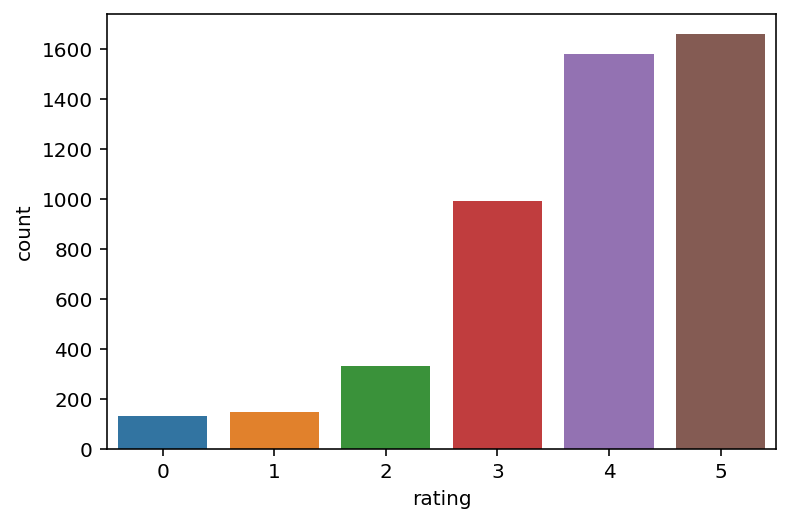

In [20]:
import seaborn as sns
sns.countplot(x=data['rating'],data=data)

In [21]:
ratings_equal_zero=data[data['rating']==0]


In [22]:
data=data[['review_id', 'rating', 'review_text']]
data.head()

,review_id,rating,review_text
0,00005dd943695f048c7348a06c6408db,2,final book mercy fall trilogy leave mixed feel...
1,0000f2fa08114079d9d7215bc5e754d2,1,reread kill mockingbird prior read go set watc...
2,0001a480a5b24fdad0633417a76b6bb0,5,satisfying conclusion entertaining series
3,0001b032e98876009c59acc94cca8194,5,cry whisper voice shake remind world ought world
4,00020adeea578404ffa05e295fb2b182,0,interested world series ya slightly campy voic...


In [23]:
rate_id_one = []
rate_id_two = []
rate_id_three = []
rate_id_four = []
rate_id_five =[]


for review_text, rating in zip(data['review_text'], data['rating']):
    line = review_text.split(" ")
    dic = {}
    if rating == 1:
        for word in line:
            dic[word] = True
        ireru = (dic, 1)
        rate_id_one.append(ireru)
    elif rating == 2:
        for word in line:
            dic[word] = True
        ireru = (dic, 2)
        rate_id_two.append(ireru) 
    elif rating == 3:
        for word in line:
            dic[word] = True
        ireru = (dic, 3)
        rate_id_three.append(ireru)
    elif rating == 4:
        for word in line:
            dic[word] = True
        ireru = (dic, 4)
        rate_id_four.append(ireru)
    else:
        for word in line:
            dic[word] = True
        ireru = (dic, 5)
        rate_id_five.append(ireru)


In [26]:
threshold = 0.8
num_one = int(threshold * len(rate_id_one))
num_two = int(threshold * len(rate_id_two))
num_three = int(threshold * len(rate_id_three))
num_four = int(threshold * len(rate_id_four))
num_five = int(threshold * len(rate_id_five))

features_train = rate_id_one[:num_one] + rate_id_two[:num_two] + rate_id_three[:num_three] + rate_id_four[:num_four] + rate_id_five[:num_five]
features_test = rate_id_one[num_one:] + rate_id_two[num_two:] + rate_id_three[num_three:] + rate_id_four[num_four:] + rate_id_five[num_five:]
print("Number of training datapoints:", len(features_train))
print("Number of test datapoints:", len(features_test))

Number of training datapoints: 3865
Number of test datapoints: 968


In [27]:
classifier = NaiveBayesClassifier.train(features_train)
print('Accuracy of the classifier:', nltk_accuracy(classifier, features_test))

Accuracy of the classifier: 0.28615702479338845


The cause may be that there is a wide range of choices from 1 to 5 and that the absolute number of low-rated sentence data is insufficient. For example, if you choose between 1 and 5 rates, it may improve.

Alternatively, if other methods are used, the accuracy may be further improved, so this will be an issue for the future.

words influenced the predicted numbers during the training.

In [28]:
N = 30
print('Top ' + str(N) + ' most informative words:')
for i, item in enumerate(classifier.most_informative_features()[:N]):
    print(str(i+1) + '. ' + item[0]) 

Top 30 most informative words:
1. 35
2. 25
3. insult
4. poorly
5. stupid
6. alley
7. eh
8. rave
9. redeeming
10. representation
11. stalk
12. trope
13. disappointing
14. meh
15. offensive
16. ridiculously
17. supposedly
18. filler
19. skim
20. thinking
21. 200
22. abusive
23. acceptable
24. advantage
25. bored
26. brown
27. dude
28. generous
29. gore
30. gross


In [ ]:
def extract_features(words):
    return dict([(word, True) for word in words])
#Divide into words like the large amount of review text earlier


print("Clothes review predictions:")

 
for i in range(0, len(data)):
    if data['rating'].iloc[i]==0 :
        input_review = data['review_text'].iloc[i]
        features = extract_features(input_review.split())
        probabilities = classifier.prob_classify(features)
        predicted_sentiment = probabilities.max()
        data['rating'].iloc[i]=predicted_sentiment
        

Clothes review predictions:


C:\Users\antoi\AppData\Local\Temp\ipykernel_7600\299568596.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rating'].iloc[i]=predicted_sentiment


In [ ]:
ratings_equal_zero = data[data['rating']==0] 
ratings_equal_zero.head()

,review_id,rating,review_text


there is no ratings equal to 0

In [ ]:
data.head(30)

,review_id,rating,review_text
1,00000dd80b43a2cf2afee588cfdd72e2,5.0,marriage mistake focus count 's young sister c...
2,00001391db9e5a03e3f13da55399d427,2.0,saw trailer movie version book fell love chara...
3,00001da050362c5a7eaf6a0614385a29,5.0,"n't expect enjoy much . great work , good idea..."
4,00002061af3a9f981f601d7f223a6b35,4.0,1999 friend mine suggest read book . try read ...
5,0000271000ca3f0ed54ec992fa502672,5.0,one book love first sentence last . cayman hil...
6,00002956a602b00f44b4d2e42eec50b8,5.0,make cry subway- really good way .
7,00002e84abd11229f94cad76a601f288,5.0,awesome read . kick put long thinking 'd hate ...
8,000039a2fc73f37e615c4acc4498116a,5.0,read many year ago still talk day . even thoug...
9,00004fead2419af82ee3c84b533dea27,5.0,'vicious ' super-powers/urban fantasy interest...
10,000062f0c7b8c3c3ca0c5c280afa3b48,4.0,story several family milwaukee struggle make r...
